У цьому ДЗ ми потренуємось розв'язувати задачу багатокласової класифікації за допомогою логістичної регресії з використанням стратегій One-vs-Rest та One-vs-One, оцінити якість моделей та порівняти стратегії.

# Опис задачі і даних

**Контекст**

В цьому ДЗ ми працюємо з даними про сегментацію клієнтів.

Сегментація клієнтів – це практика поділу бази клієнтів на групи індивідів, які схожі між собою за певними критеріями, що мають значення для маркетингу, такими як вік, стать, інтереси та звички у витратах.

Компанії, які використовують сегментацію клієнтів, виходять з того, що кожен клієнт є унікальним і що їхні маркетингові зусилля будуть більш ефективними, якщо вони орієнтуватимуться на конкретні, менші групи зі зверненнями, які ці споживачі вважатимуть доречними та які спонукатимуть їх до купівлі. Компанії також сподіваються отримати глибше розуміння уподобань та потреб своїх клієнтів з метою виявлення того, що кожен сегмент цінує найбільше, щоб точніше адаптувати маркетингові матеріали до цього сегменту.

**Зміст**.

Автомобільна компанія планує вийти на нові ринки зі своїми існуючими продуктами (P1, P2, P3, P4 і P5). Після інтенсивного маркетингового дослідження вони дійшли висновку, що поведінка нового ринку схожа на їхній існуючий ринок.

На своєму існуючому ринку команда з продажу класифікувала всіх клієнтів на 4 сегменти (A, B, C, D). Потім вони здійснювали сегментовані звернення та комунікацію з різними сегментами клієнтів. Ця стратегія працювала для них надзвичайно добре. Вони планують використати ту саму стратегію на нових ринках і визначили 2627 нових потенційних клієнтів.

Ви маєте допомогти менеджеру передбачити правильну групу для нових клієнтів.

В цьому ДЗ використовуємо дані `customer_segmentation_train.csv`[скачати дані](https://drive.google.com/file/d/1VU1y2EwaHkVfr5RZ1U4MPWjeflAusK3w/view?usp=sharing). Це `train.csv`з цього [змагання](https://www.kaggle.com/datasets/abisheksudarshan/customer-segmentation/data?select=train.csv)

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import classification_report

pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.max.columns', 100)

# **Завдання 1.**
Завантажте та підготуйте датасет до аналізу. Виконайте обробку пропущених значень та необхідне кодування категоріальних ознак. Розбийте на тренувальну і тестувальну вибірку, де в тесті 20%. Памʼятаємо, що весь препроцесинг ліпше все ж тренувати на тренувальній вибірці і на тестувальній лише використовувати вже натреновані трансформери.
Але в даному випадку оскільки значень в категоріях небагато, можна зробити обробку і на оригінальних даних, а потім розбити - це простіше. Можна також реалізувати процесинг і тренування моделі з пайплайнами. Обирайте як вам зручніше.

In [2]:
raw_df = pd.read_csv('./data/customer_segmentation_train.csv')
raw_df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.00,Low,4.00,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.00,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.00,Low,1.00,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.00,High,2.00,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.00,Cat_6,A


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [4]:
raw_df.describe().round(2)

,ID,Age,Work_Experience,Family_Size
count,8068.00,8068.00,7239.00,7733.00
mean,463479.21,43.47,2.64,2.85
std,2595.38,16.71,3.41,1.53
min,458982.00,18.00,0.00,1.00
25%,461240.75,30.00,0.00,2.00
50%,463472.50,40.00,1.00,3.00
75%,465744.25,53.00,4.00,4.00
max,467974.00,89.00,14.00,9.00


In [5]:
raw_df.describe(include='object')

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,7928,7990,7944,8068,7992,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4643,4968,2516,4878,5238,2268


This dataset contains 4 numeric columns and 7 categorical columns. All values appear to be correct.

Categorical column such as `Gender`, `Ever_Married` and `Graduated` have only 2 unique values (binary columns). Other categorical columns contain between 3 and 9 unique categories. 

Columns `ID` will not be used in the model.

## Analysis of the target column `Segmentation`

In [6]:
raw_df['Segmentation'].value_counts().sort_values(ascending=False)

Segmentation
D    2268
A    1972
C    1970
B    1858
Name: count, dtype: int64

In [7]:
raw_df['Segmentation'].value_counts(normalize=True).sort_values(ascending=False) * 100

Segmentation
D   28.11
A   24.44
C   24.42
B   23.03
Name: proportion, dtype: float64

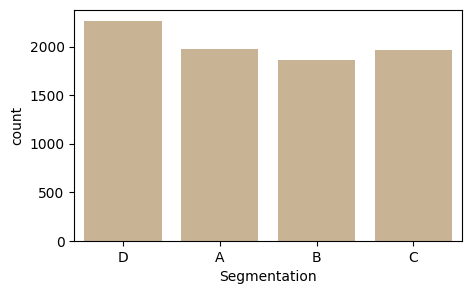

In [8]:
plt.figure(figsize=(5, 3))
sns.countplot(data=raw_df, x='Segmentation', color='tan')
plt.show()

We are dealing with a multiclass classification task.

## Missing values
Let's examine the missing values.

In [9]:
raw_df.isna().sum() / len(raw_df) * 100

ID                 0.00
Gender             0.00
Ever_Married       1.74
Age                0.00
Graduated          0.97
Profession         1.54
Work_Experience   10.28
Spending_Score     0.00
Family_Size        4.15
Var_1              0.94
Segmentation       0.00
dtype: float64

### `Work_Experience`

In [11]:
def count_missing_values(df, column):
    num_rows = df.shape[0]
    null_count = df[column].isna().sum()

    result_df = pd.DataFrame([{
        'column_name': column,
        'null_count': null_count,
        'null_percentage': null_count/num_rows * 100}])
    return result_df

In [12]:
count_missing_values(raw_df, 'Work_Experience')

,column_name,null_count,null_percentage
0,Work_Experience,829,10.28


In [13]:
raw_df['Work_Experience'].value_counts(dropna=False)

Work_Experience
1.00     2354
0.00     2318
NaN       829
9.00      474
8.00      463
2.00      286
3.00      255
4.00      253
6.00      204
7.00      196
5.00      194
10.00      53
11.00      50
12.00      48
13.00      46
14.00      45
Name: count, dtype: int64

In [14]:
def dist_box(dataset, column):
    fig, ax = plt.subplots(1, 2, figsize=(16, 7))

    sns.histplot(dataset[column], color='tan', ax=ax[0])
    pltname = f'Distribution plot for {column}'
    ax[0].set_title(pltname)

    sns.boxplot(y=column, data=dataset, color='tan')
    pltname = f'Boxplot for {column}'
    ax[1].set_title(pltname)
    plt.show()

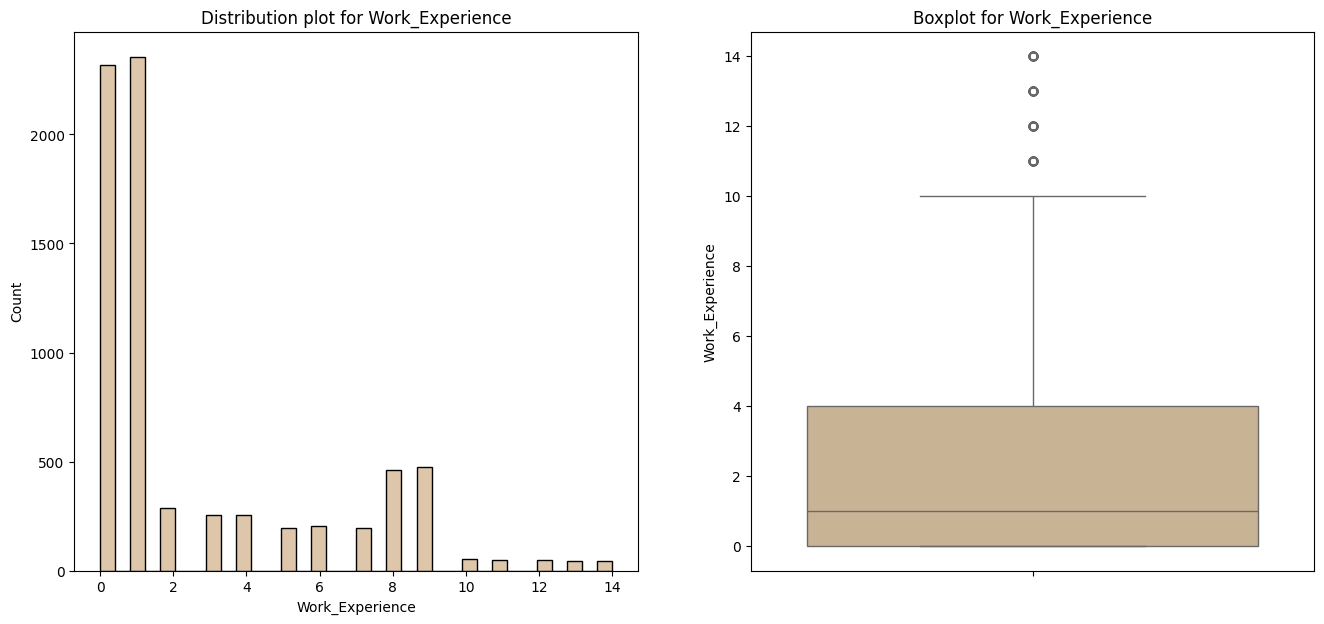

In [15]:
dist_box(raw_df, 'Work_Experience')

In [16]:
def calculate_statistics(df, column):
    mean = df[column].mean()
    median = df[column].median()
    mode = df[column].mode()[0]

    print(f"{column} column")
    print(f"Mean value: {mean:.2f}")
    print(f"Median value: {median:.2f}")
    print(f"Mode value: {mode}")

In [17]:
calculate_statistics(raw_df, 'Work_Experience')

Work_Experience column
Mean value: 2.64
Median value: 1.00
Mode value: 1.0


- The data distribution is compact and has outliers (11, 12, 13, and 14 years of work experience)
- The median and most frequent value have the same value: 1
- Average value is 2.64
- The average value is greater than the median and the mode
- Although the mean and mode are the same value and can be used for imputation, since the percentage missing is large (10.28%), it is better to leave the data as is and not impute. If the method requires imputing, we can impute the data using the median and create another column indicating which values ​​were imputed.

### `Family_Size`

In [18]:
count_missing_values(raw_df, 'Family_Size')

,column_name,null_count,null_percentage
0,Family_Size,335,4.15


In [19]:
raw_df['Family_Size'].value_counts(dropna=False)

Family_Size
2.00    2390
3.00    1497
1.00    1453
4.00    1379
5.00     612
NaN      335
6.00     212
7.00      96
8.00      50
9.00      44
Name: count, dtype: int64

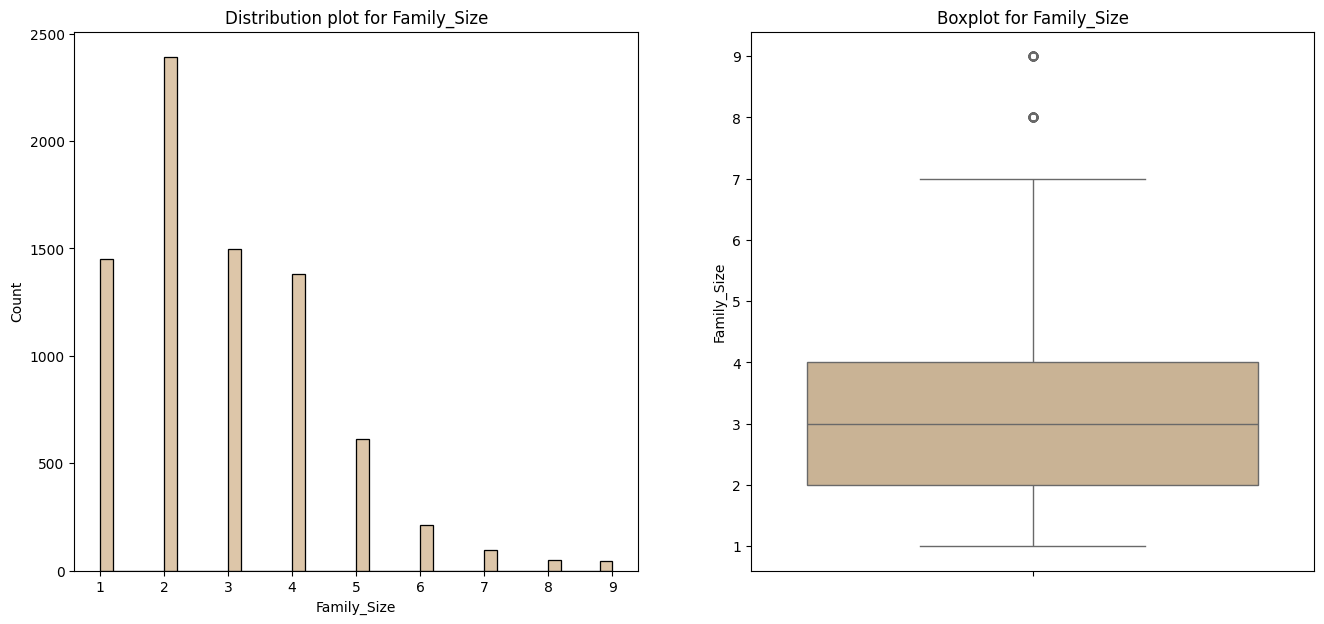

In [20]:
dist_box(raw_df, 'Family_Size')

In [21]:
calculate_statistics(raw_df, 'Family_Size')

Family_Size column
Mean value: 2.85
Median value: 3.00
Mode value: 2.0


- The data distribution is compact and has outliers (8 and 9 family members)
- The median value is 3
- The most frequent value is 2
- Average value is 2.85
- We can use median value for imputation and create another column indicating which values ​​were imputed.

### `Ever_Married`


In [22]:
count_missing_values(raw_df, 'Ever_Married')

,column_name,null_count,null_percentage
0,Ever_Married,140,1.74


In [23]:
raw_df['Ever_Married'].value_counts(dropna=False)

Ever_Married
Yes    4643
No     3285
NaN     140
Name: count, dtype: int64

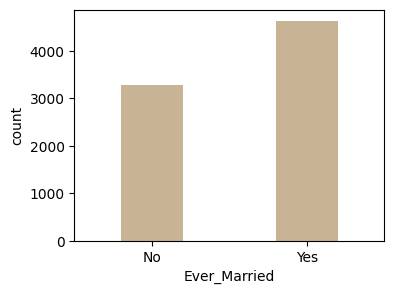

In [24]:
plt.figure(figsize=(4, 3))
sns.countplot(data=raw_df, x='Ever_Married', color='tan', width=0.4)
plt.show()

- The most of clients were ever married.
- We could impute missing value with the majority category `Yes`

### `Graduated`

In [25]:
count_missing_values(raw_df, 'Graduated')

,column_name,null_count,null_percentage
0,Graduated,78,0.97


In [26]:
raw_df['Graduated'].value_counts(dropna=False)

Graduated
Yes    4968
No     3022
NaN      78
Name: count, dtype: int64

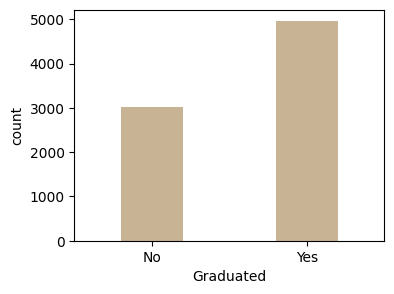

In [27]:
plt.figure(figsize=(4, 3))
sns.countplot(data=raw_df, x='Graduated', color='tan', width=0.4)
plt.show()

- The most of clients were graduated.
- We could impute missing value with the majority category `Yes`

### `Profession`

In [28]:
count_missing_values(raw_df, 'Profession')

,column_name,null_count,null_percentage
0,Profession,124,1.54


In [29]:
raw_df['Profession'].value_counts(dropna=False)

Profession
Artist           2516
Healthcare       1332
Entertainment     949
Engineer          699
Doctor            688
Lawyer            623
Executive         599
Marketing         292
Homemaker         246
NaN               124
Name: count, dtype: int64

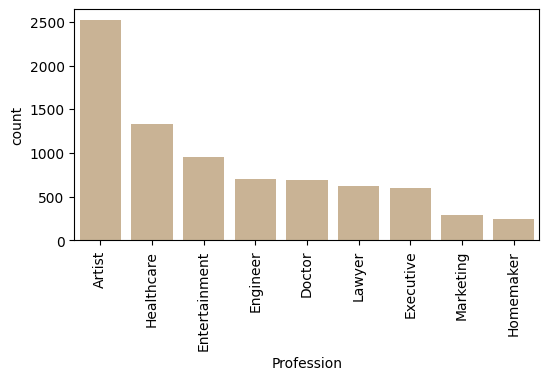

In [30]:
plt.figure(figsize=(6, 3))
sns.countplot(data=raw_df, x='Profession',
              order=raw_df['Profession'].value_counts().index,
              color='tan')
plt.xticks(rotation=90)
plt.show()

- The most of clients have such profession as `Artist`.
- We could impute missing value `Unknown` value.

### `Var_1`

In [31]:
count_missing_values(raw_df, 'Var_1')

,column_name,null_count,null_percentage
0,Var_1,76,0.94


In [32]:
raw_df['Var_1'].value_counts(dropna=False)

Var_1
Cat_6    5238
Cat_4    1089
Cat_3     822
Cat_2     422
Cat_7     203
Cat_1     133
Cat_5      85
NaN        76
Name: count, dtype: int64

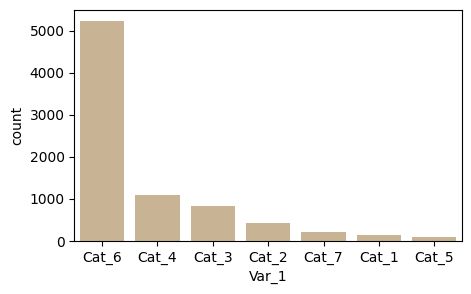

In [33]:
plt.figure(figsize=(5, 3))
sns.countplot(data=raw_df, x='Var_1',
              order=raw_df['Var_1'].value_counts().index,
              color='tan')
plt.show()

In [34]:
raw_df['Var_1'].value_counts(normalize=True, dropna=False) * 100

Var_1
Cat_6   64.92
Cat_4   13.50
Cat_3   10.19
Cat_2    5.23
Cat_7    2.52
Cat_1    1.65
Cat_5    1.05
NaN      0.94
Name: proportion, dtype: float64

- Most clients belong to the `Cat_6` category
- The `Cat_6` category represents 64.92% of all clients
- Therefore, we could impute the missing values in `Var_1` with `Cat_6` or assign them an `Unknown` value

## `Spending_Score`

In [35]:
raw_df['Spending_Score'].value_counts(dropna=False)

Spending_Score
Low        4878
Average    1974
High       1216
Name: count, dtype: int64

For the `Spending_Score` column, we could use `OrdinalEncoder`, due to categories exhibits clear and meaningful order `Low` > `Average` > `High`.

## Split on train and test sets

In [36]:
raw_df.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [37]:
input_cols = list(raw_df.columns)[1:-1]
target_col = 'Segmentation'

train_inputs, test_inputs, train_targets, test_targets = train_test_split(
    raw_df[input_cols], raw_df[target_col],
    test_size=0.2,
    random_state=24,
    stratify=raw_df[target_col]
)

print(f"train_inputs.shape: {train_inputs.shape}")
print(f"train_targets.shape: {train_targets.shape}")
print(f"test_inputs.shape: {test_inputs.shape}")
print(f"test_targets.shape: {test_targets.shape}")

train_inputs.shape: (6454, 9)
train_targets.shape: (6454,)
test_inputs.shape: (1614, 9)
test_targets.shape: (1614,)


In [38]:
numeric_cols = train_inputs.select_dtypes('number').columns.to_list()
numeric_cols

['Age', 'Work_Experience', 'Family_Size']

## Preprocessing

### Imputation

In [39]:
binary_cols = ['Gender', 'Ever_Married', 'Graduated']
one_hot_unknown_cols = ['Profession']
one_hot_most_freq_cols = ['Var_1']

# most_freq_cols =  ['Gender', 'Ever_Married', 'Graduated', 'Var_1']
# unknown_cols = ['Profession']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', MinMaxScaler())
])

cat_impute_most_freq = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
])

cat_transform_const = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown'))
])


imputer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('most_frequent_impute', cat_impute_most_freq, binary_cols + one_hot_most_freq_cols),
        ('unknown_impute', cat_transform_const, one_hot_unknown_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
)

imputer.set_output(transform='pandas')

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Age', 'Work_Experience', 'Family_Size']),
                                ('most_frequent_impute',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='most_frequent'))]),
                                 ['Gender', 'Ever_Married', 'Graduated',
                                  'Var_1']),
                                ('unknown_impute',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant'))]),
                                 ['Profession'])],
                  verbose_feature_names_out=False)

In [40]:
imputer.fit(train_inputs)

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Age', 'Work_Experience', 'Family_Size']),
                                ('most_frequent_impute',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='most_frequent'))]),
                                 ['Gender', 'Ever_Married', 'Graduated',
                                  'Var_1']),
                                ('unknown_impute',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant'))]),
                                 ['Profession'])],
                  verbose_feature_names_out=False)

In [41]:
train_inputs_filled = imputer.transform(train_inputs)
test_inputs_filled = imputer.transform(test_inputs)

In [42]:
train_inputs_filled.head()

,Age,Work_Experience,Family_Size,missingindicator_Work_Experience,missingindicator_Family_Size,Gender,Ever_Married,Graduated,Var_1,missingindicator_Ever_Married,missingindicator_Graduated,missingindicator_Var_1,Profession,Spending_Score
5187,0.39,0.00,0.12,0.00,0.00,Male,Yes,Yes,Cat_6,False,False,False,Artist,Average
2727,0.68,0.07,0.12,0.00,0.00,Male,Yes,Yes,Cat_6,False,False,False,Artist,High
7510,0.28,0.00,0.25,0.00,0.00,Male,Yes,No,Cat_4,False,False,False,Engineer,Average
1670,0.79,0.07,0.00,0.00,0.00,Female,Yes,No,Cat_6,False,False,False,Lawyer,Low
3881,0.27,0.00,0.00,0.00,0.00,Male,No,Yes,Cat_6,False,False,False,Artist,Low


### Encoding

In [43]:
ordinal_cols = ['Spending_Score']
cat_impute_cols = (train_inputs_filled
                   .drop(ordinal_cols, axis=1)
                   .select_dtypes('object')
                   .columns.to_list())

onehot_transformer = Pipeline(steps=[
    ('onehot_enc', OneHotEncoder(drop='if_binary',
                                 sparse_output=False,
                                 handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('ord_enc', OrdinalEncoder(categories=[['Low', 'Average', 'High']]))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_enc', onehot_transformer, cat_impute_cols),
        ('ord_enc', ordinal_transformer, ordinal_cols)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False,
    force_int_remainder_cols=False
)

preprocessor.set_output(transform='pandas')

preprocessor.fit(train_inputs_filled)

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('one_hot_enc',
                                 Pipeline(steps=[('onehot_enc',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Gender', 'Ever_Married', 'Graduated',
                                  'Var_1', 'missingindicator_Ever_Married',
                                  'missingindicator_Graduated',
                                  'missingindicator_Var_1', 'Profession']),
                                ('ord_enc',
                                 Pipeline(steps=[('ord_enc',
                                                  OrdinalEncoder(categories=[['Low',
                                                                              'Average',
                                                                              'High']]))]),
                                 ['Spending_Score'])],
                  verbose_feature_names_out=False)

In [44]:
train_inputs_transform = preprocessor.fit_transform(train_inputs_filled)
test_inputs_transform = preprocessor.transform(test_inputs_filled)

In [45]:
train_inputs_transform.head()

,Gender_Male,Ever_Married_Yes,Graduated_Yes,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,missingindicator_Ever_Married_True,missingindicator_Graduated_True,missingindicator_Var_1_True,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Profession_Unknown,Spending_Score,Age,Work_Experience,Family_Size,missingindicator_Work_Experience,missingindicator_Family_Size
5187,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.39,0.00,0.12,0.00,0.00
2727,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.68,0.07,0.12,0.00,0.00
7510,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.28,0.00,0.25,0.00,0.00
1670,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.79,0.07,0.00,0.00,0.00
3881,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.27,0.00,0.00,0.00,0.00


In [46]:
train_inputs_transform.shape, test_inputs_transform.shape

((6454, 29), (1614, 29))

# **Завдання 2.**
Важливо уважно прочитати все формулювання цього завдання до кінця!**

Застосуйте методи ресемплингу даних SMOTE та SMOTE-Tomek з бібліотеки imbalanced-learn до тренувальної вибірки. В результаті у Вас має вийти 2 тренувальних набори: з апсемплингом зі SMOTE, та з ресамплингом з SMOTE-Tomek.

Увага! В нашому наборі даних є як категоріальні дані, так і звичайні числові. Базовий SMOTE не буде правильно працювати з категоріальними даними, але є його модифікація, яка буде. Тому в цього завдання є 2 виконання

  1. Застосувати SMOTE базовий лише на НЕкатегоріальних ознаках.

  2. Переглянути інформацію про метод [SMOTENC](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html#imblearn.over_sampling.SMOTENC) і використати цей метод в цій задачі. За цей спосіб буде +3 бали за це завдання і він рекомендований для виконання.

  **Підказка**: аби скористатись SMOTENC треба створити змінну, яка містить індекси ознак, які є категоріальними (їх номер серед колонок) і передати при ініціації екземпляра класу `SMOTENC(..., categorical_features=cat_feature_indeces)`.
  
  Ви також можете розглянути варіант використання варіації SMOTE, який працює ЛИШЕ з категоріальними ознаками [SMOTEN](https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTEN.html)

### SMOTENC

In [47]:
categorical_features_indeces = [idx for idx, col in enumerate(train_inputs_filled.columns)
                                if train_inputs_filled[col].dtype == 'object']
categorical_features_indeces

[5, 6, 7, 8, 9, 10, 11, 12, 13]

In [48]:
smotenc = SMOTENC(categorical_features=categorical_features_indeces, random_state=24)

In [49]:
train_inputs_smotenc, train_targets_smotenc = smotenc.fit_resample(train_inputs_filled,
                                                                   train_targets)

In [50]:
print(f"train_inputs shape before resampling: {train_inputs_filled.shape}")
print(f"train_inputs shape after resampling with SMOTENC: {train_inputs_smotenc.shape}")

train_inputs shape before resampling: (6454, 14)
train_inputs shape after resampling with SMOTENC: (7256, 14)


In [51]:
train_targets_smotenc.value_counts()

Segmentation
B    1814
C    1814
A    1814
D    1814
Name: count, dtype: int64

### SMOTETomek

In [52]:
smotetomec = SMOTETomek(random_state=24)

train_inputs_smotetomek, train_targets_smotetomek = smotetomec.fit_resample(
    train_inputs_transform,
    train_targets)

print(f"train_inputs shape before resampling: {train_inputs_transform.shape}")
print(f"train_inputs shape after resampling with SMOTETomek: {train_inputs_smotetomek.shape}")


train_inputs shape before resampling: (6454, 29)
train_inputs shape after resampling with SMOTETomek: (5780, 29)


In [53]:
train_targets_smotetomek.value_counts()

Segmentation
D    1488
C    1472
A    1421
B    1399
Name: count, dtype: int64

# **Завдання 3**.
  1. Навчіть модель логістичної регресії з використанням стратегії One-vs-Rest з логістичною регресією на оригінальних даних, збалансованих з SMOTE, збалансованих з Smote-Tomek.  
  2. Виміряйте якість кожної з натренованих моделей використовуючи `sklearn.metrics.classification_report`.
  3. Напишіть, яку метрику ви обрали для порівняння моделей.
  4. Яка модель найкраща?
  5. Якщо немає суттєвої різниці між моделями - напишіть свою гіпотезу, чому?

## One-vs-Rest without resampling

In [54]:
log_reg = LogisticRegression(solver='liblinear', random_state=24)
ovr_model = OneVsRestClassifier(log_reg)
ovr_model.fit(train_inputs_transform, train_targets)

ovr_predictions = ovr_model.predict(test_inputs_transform)

print(classification_report(test_targets, ovr_predictions))

              precision    recall  f1-score   support

           A       0.44      0.49      0.46       394
           B       0.45      0.19      0.26       372
           C       0.50      0.64      0.56       394
           D       0.60      0.69      0.64       454

    accuracy                           0.51      1614
   macro avg       0.50      0.50      0.48      1614
weighted avg       0.50      0.51      0.49      1614



## One-vs-Rest with SMOTENC resampling

Since we applied SMOTENC to data without prior encoding (only filling missing values), we need to preprocess and encode the data first.

In [62]:
train_inputs_smotenc_transform = preprocessor.fit_transform(train_inputs_smotenc)
test_inputs_smotenc_transform = preprocessor.transform(test_inputs_filled)

ovr_smotenc_model = ovr_model.fit(train_inputs_smotenc_transform, train_targets_smotenc)

ovr_smotenc_predictions = ovr_smotenc_model.predict(test_inputs_smotenc_transform)

print(classification_report(test_targets, ovr_smotenc_predictions))

              precision    recall  f1-score   support

           A       0.44      0.52      0.47       394
           B       0.42      0.23      0.30       372
           C       0.51      0.60      0.55       394
           D       0.63      0.66      0.65       454

    accuracy                           0.51      1614
   macro avg       0.50      0.50      0.49      1614
weighted avg       0.51      0.51      0.50      1614



In [63]:
ovr_smotenc_model.predict_proba(test_inputs_transform)[:10].round(2)

array([[0.14, 0.32, 0.53, 0.01],
       [0.42, 0.28, 0.14, 0.16],
       [0.3 , 0.32, 0.28, 0.1 ],
       [0.28, 0.34, 0.34, 0.04],
       [0.15, 0.34, 0.5 , 0.01],
       [0.07, 0.11, 0.31, 0.51],
       [0.07, 0.06, 0.1 , 0.77],
       [0.36, 0.36, 0.23, 0.06],
       [0.21, 0.37, 0.34, 0.09],
       [0.39, 0.19, 0.09, 0.32]])

In [57]:
pd.DataFrame({'true': test_targets, 'predict': ovr_smotenc_predictions})[:10]

,true,predict
1355,B,C
5153,A,A
7278,B,B
962,A,C
2927,C,C
6794,A,D
4524,D,D
2091,C,B
6297,C,B
2325,A,A


We observe that the model lacks confidence in its predictions, as it assigns law probabilities to all classes.

## One-vs-Rest with SMOTE-Tomek resampling

In [58]:
ovr_smotetomek_model = ovr_model.fit(train_inputs_smotetomek, train_targets_smotetomek)

ovr_smotetomek_predictions = ovr_smotetomek_model.predict(test_inputs_transform)

print(classification_report(test_targets, ovr_smotetomek_predictions))

              precision    recall  f1-score   support

           A       0.43      0.53      0.47       394
           B       0.39      0.20      0.27       372
           C       0.52      0.61      0.56       394
           D       0.63      0.65      0.64       454

    accuracy                           0.51      1614
   macro avg       0.49      0.50      0.49      1614
weighted avg       0.50      0.51      0.50      1614



- To compare performance, we used weighted average precision, recall and F1-score because we are dealing with an imbalanced multiclass task.

- All models show similar results, but resampling with SMOTENC performs slightly better. 

- All models perform the worst for class B. 

- The metrics values around 0.5 are not good, these models are only slightly better than random guessing. Maybe, we need another model (not OneVsRest, maybe OneVsOne), or more data.

In [59]:
ovo_model = OneVsOneClassifier(log_reg)
ovo_model.fit(train_inputs_transform, train_targets)

ovo_smotenc_model = ovo_model.fit(train_inputs_smotenc_transform, train_targets_smotenc)

ovo_smotenc_predictions = ovo_smotenc_model.predict(test_inputs_transform)

print(classification_report(test_targets, ovo_smotenc_predictions))

              precision    recall  f1-score   support

           A       0.43      0.49      0.46       394
           B       0.43      0.32      0.37       372
           C       0.53      0.58      0.55       394
           D       0.63      0.65      0.64       454

    accuracy                           0.52      1614
   macro avg       0.51      0.51      0.50      1614
weighted avg       0.51      0.52      0.51      1614



Using OneVsOneClassifier doesn't provide significantly better predictions.